# Getting Tweets
Script below will download tweets in batches of 3200

In [ ]:
!pip install tweepy

In [ ]:
import tweepy #https://github.com/tweepy/tweepy
import csv

#Twitter API credentials
consumer_key = "EFoEOrZtNntr18ZYKtLuFuqeU"
consumer_secret = "1Xc0urIToXsf5MRYcO3P5o13zTAVj56UtctP45qzvrieRLpvTZ"
access_key = "1364172333741723651-QFPnDAgiQ6UVuxotXpHtIVUqZOTQII"
access_secret = "5l0aJoJiL2ZLOuuExnAofqYImbWNhLLMgl9DOLOe9IcGj"


def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print(f"getting tweets before {oldest}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"...{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text] for tweet in alltweets]
    
    #write the csv  
    with open(f'new_{screen_name}_tweets.csv', 'w', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)
    
    pass


if __name__ == '__main__':
	#pass in the username of the account you want to download
	get_all_tweets("vitalikbuterin")

# Sentiment analysis

In [1]:
!pip install twython


## Imports 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for getting date data type
import datetime

#for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#This enables showing all output, not just most recent
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lewis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Vitalik Buterin - Creator of Ethereum

Get Vitalik tweets

In [4]:
vitalikbuterin_tweets_base = pd.read_excel('vitalikbuterin_user_tweets.xlsx', index_col=0)  
vitalikbuterin_tweets_clean = vitalikbuterin_tweets_base.copy()

#filter columns
vitalikbuterin_tweets_clean.drop(vitalikbuterin_tweets_clean.columns.difference(['Text','UTC','Favorites','Retweets']), 1, inplace=True)

#fix date column. We only want first 10 characters and then we want them as date type
vitalikbuterin_tweets_clean['UTC'] = vitalikbuterin_tweets_clean['UTC'].str[:10].astype(str)
vitalikbuterin_tweets_clean['UTC'] = pd.to_datetime(vitalikbuterin_tweets_clean['UTC'])
#finally change name of UTC column to Date
vitalikbuterin_tweets_clean = vitalikbuterin_tweets_clean.rename(columns={'UTC': 'Date'})

In [5]:
vitalikbuterin_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 1362399831826849797 to 1271465277239300102
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Text       3200 non-null   object        
 1   Date       3200 non-null   datetime64[ns]
 2   Favorites  3200 non-null   int64         
 3   Retweets   3200 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 125.0+ KB


Run Vitalik tweets through vader model

In [6]:
myData = vitalikbuterin_tweets_clean.copy()

myData['scores'] = myData['Text'].apply(lambda review: sid.polarity_scores(review))

myData['compound'] = myData['scores'].apply(lambda score_dict: score_dict['compound'])
myData['comp_score'] = myData['compound'].apply(lambda c: 'positive' if c >= 0 else 'negative')

Above creates three additional columns: scores, compound, comp_score.

Below is a plot of the counts, as we can see Vitaliks tweets are largely positive. 

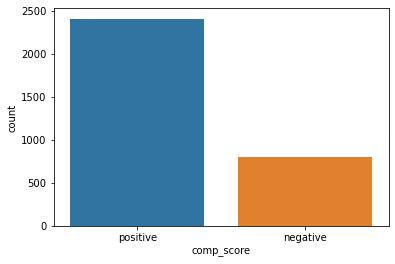

In [7]:
sns.countplot(x='comp_score', data=myData)


## Getting Ethereum data

As Vitalik is the creator of ethereum, we will be comparing his tweets to ethereum prices. First we have to get ethereum data.

In [8]:
eth_base = pd.read_csv("ETH.csv")

#source: https://www.coindesk.com/price/ethereum


We will now clean the ETH data by turning the date column into date type, dropping redundant columns, and then feature engineering additional columns showing change since previous day and change tomorrow

In [9]:
eth_clean = eth_base.copy()
#turn date column into date type
eth_clean['Date'] = pd.to_datetime(eth_clean['Date'])

#Create column for previous days closing price
eth_clean['Prev_Closing'] = eth_clean['Closing Price (USD)'].shift(1)
eth_clean['tomorrow_Closing'] = eth_clean['Closing Price (USD)'].shift(-1)
eth_clean = eth_clean.drop(['24h Open (USD)', '24h High (USD)', '24h Low (USD)'], axis =1)


#Create column for daily change since yesterday
eth_clean['change_since_yesterday'] = (eth_clean['Closing Price (USD)'] - eth_clean['Prev_Closing']) / eth_clean['Prev_Closing']
eth_clean['tomorrow_change'] = (eth_clean['tomorrow_Closing'] - eth_clean['Closing Price (USD)']) / eth_clean['Closing Price (USD)']

eth_clean

,Currency,Date,Closing Price (USD),Prev_Closing,tomorrow_Closing,change_since_yesterday,tomorrow_change
0,ETH,2015-09-08,0.909046,NaN,0.692321,NaN,-0.238409
1,ETH,2015-10-08,0.692321,0.909046,0.668067,-0.238409,-0.035033
2,ETH,2015-11-08,0.668067,0.692321,0.850151,-0.035033,0.272554
3,ETH,2015-12-08,0.850151,0.668067,1.266023,0.272554,0.489174
4,ETH,2015-08-13,1.266023,0.850151,1.951460,0.489174,0.541410
...,...,...,...,...,...,...,...
1981,ETH,2021-02-19,1958.739190,1936.715286,1855.264841,0.011372,-0.052827
1982,ETH,2021-02-20,1855.264841,1958.739190,1913.800284,-0.052827,0.031551
1983,ETH,2021-02-21,1913.800284,1855.264841,1782.149591,0.031551,-0.068790
1984,ETH,2021-02-22,1782.149591,1913.800284,1546.622961,-0.068790,-0.132159


Join ETH data to df with Vitali' sentiment analysis. Join by date keeping all sentiment analysis rows and only ETH rows that have matching dates. Each date will have one row for price info however may have multiple tweets (and so multiple rows) as such rows from ETH df may need to be duplicated.

In [10]:
myData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 1362399831826849797 to 1271465277239300102
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Text        3200 non-null   object        
 1   Date        3200 non-null   datetime64[ns]
 2   Favorites   3200 non-null   int64         
 3   Retweets    3200 non-null   int64         
 4   scores      3200 non-null   object        
 5   compound    3200 non-null   float64       
 6   comp_score  3200 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 360.0+ KB


In [11]:
Vitalik_eth_combined = pd.merge(myData, eth_clean)

In [12]:
#checking data is okay
Vitalik_eth_combined.isnull().sum()

#Clean data
#remove first and last values
Vitalik_eth_combined

Text                      0
Date                      0
Favorites                 0
Retweets                  0
scores                    0
compound                  0
comp_score                0
Currency                  0
Closing Price (USD)       0
Prev_Closing              0
tomorrow_Closing          0
change_since_yesterday    0
tomorrow_change           0
dtype: int64

,Text,Date,Favorites,Retweets,scores,compound,comp_score,Currency,Closing Price (USD),Prev_Closing,tomorrow_Closing,change_since_yesterday,tomorrow_change
0,Some reflections on my experiences participati...,2021-02-18,1761,315,"{'neg': 0.0, 'neu': 0.915, 'pos': 0.085, 'comp...",0.3612,positive,ETH,1936.715286,1835.991463,1958.739190,0.054861,0.011372
1,A doc detailing a proposal for the first hard ...,2021-02-15,2111,456,"{'neg': 0.141, 'neu': 0.624, 'pos': 0.235, 'co...",0.6549,positive,ETH,1787.122941,1828.092656,1763.751671,-0.022411,-0.013078
2,I sent some! https://t.co/mfYrz35zjF\n\nYou sh...,2021-02-01,3273,571,"{'neg': 0.059, 'neu': 0.86, 'pos': 0.082, 'com...",0.2225,positive,ETH,771.475757,730.035168,976.892681,0.056765,0.266265
3,I make another attempt to explain how zk-SNARK...,2021-01-26,3092,679,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,positive,ETH,1350.736956,1324.858487,1247.656556,0.019533,-0.076314
4,RT @year_progress : ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓ 100%,2021-01-01,0,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,positive,ETH,730.035168,741.118404,771.475757,-0.014955,0.056765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,RT @OnlyAfricaFacts : Here's a letter King Leo...,2020-06-12,0,0,"{'neg': 0.025, 'neu': 0.975, 'pos': 0.0, 'comp...",-0.0772,negative,ETH,592.615924,592.409201,589.663019,0.000349,-0.004983
3164,The privacy flippening: when the risks of onli...,2020-06-12,343,61,"{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'comp...",-0.5719,negative,ETH,592.615924,592.409201,589.663019,0.000349,-0.004983
3165,@nalaiqpaanda Maybe the exchange lost all acce...,2020-06-12,8,0,"{'neg': 0.204, 'neu': 0.796, 'pos': 0.0, 'comp...",-0.3182,negative,ETH,592.615924,592.409201,589.663019,0.000349,-0.004983
3166,@d1m9enG Possible on any platform.,2020-06-12,42,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,positive,ETH,592.615924,592.409201,589.663019,0.000349,-0.004983


Now that we have a merged dataframe the next step is to see whether sentiment correlates to return

In [13]:
#Check average change
Vitalik_eth_combined['change_since_yesterday'].describe()
Vitalik_eth_combined['tomorrow_change'].describe()


count    3168.000000
mean        0.002520
std         0.037015
min        -0.150253
25%        -0.020718
50%         0.000349
75%         0.022473
max         0.156425
Name: change_since_yesterday, dtype: float64

count    3168.000000
mean       -0.002049
std         0.052614
min        -0.345295
25%        -0.015665
50%        -0.002075
75%         0.021105
max         0.266265
Name: tomorrow_change, dtype: float64

Going to group results by comp score and see how metrics vary based on whether the tweet was positive or negative. Too many columns so going to drop a few for easier analysis. 

In [14]:
Vitalik_eth_future = Vitalik_eth_combined[['compound','comp_score','tomorrow_change']]
Vitalik_eth_future.groupby(['comp_score']).describe()

compound                                                       \
              count      mean       std     min      25%     50%     75%   
comp_score                                                                 
negative      783.0 -0.418832  0.246643 -0.9723 -0.58955 -0.4003 -0.2144   
positive     2385.0  0.362087  0.310582  0.0000  0.00000  0.3612  0.6369   

                   tomorrow_change                                          \
               max           count      mean       std       min       25%   
comp_score                                                                   
negative   -0.0003           783.0 -0.002172  0.053426 -0.345295 -0.020718   
positive    0.9708          2385.0 -0.002008  0.052355 -0.345295 -0.015665   

                                          
                 50%       75%       max  
comp_score                                
negative   -0.001879  0.023677  0.106078  
positive   -0.002075  0.021105  0.266265

From the above we can see that both positive and negative tweets, on average, yield very similiar returns the next day. Both are negative ~ 0.002. Interestingly the median return is higher for tweets the day following negative tweets.

Instead we will look to see whether compound (the continous variable representing sentiment) correlates with daily change.

In [15]:
Vitalik_eth_future['compound'].corr(Vitalik_eth_future['tomorrow_change'])
Vitalik_eth_combined['compound'].corr(Vitalik_eth_combined['change_since_yesterday'])

0.0020801122881692917

-0.010078193036164917

As we can see the correlation is very weak and so we can conclude that the sentiment of Vitaliks tweets can not act as a predictor to ETH price changes. It also does not correlate with the previous days change and as such we can say past changes do not seem to impact his sentiment.

Looking at cases which are more positve or negative. For this we pick an aribitrary limit of 50% as at this point the classifer has sufficient certainty. 

In [16]:

vitalik_over50 = Vitalik_eth_future.copy()
vitalik_under50 = Vitalik_eth_future.copy()

vitalik_over50 = vitalik_over50[vitalik_over50.compound > 0.5]
vitalik_under50= vitalik_under50[vitalik_under50.compound < -0.5]


eth_clean['tomorrow_change'].describe()
Vitalik_eth_future['tomorrow_change'].describe()
vitalik_over50['tomorrow_change'].describe()
vitalik_under50['tomorrow_change'].describe()

count    1985.000000
mean        0.005883
std         0.066383
min        -0.345295
25%        -0.022488
50%         0.001414
75%         0.029654
max         0.541410
Name: tomorrow_change, dtype: float64

count    3168.000000
mean       -0.002049
std         0.052614
min        -0.345295
25%        -0.015665
50%        -0.002075
75%         0.021105
max         0.266265
Name: tomorrow_change, dtype: float64

count    864.000000
mean      -0.002096
std        0.048734
min       -0.345295
25%       -0.015665
50%       -0.002075
75%        0.020350
max        0.106078
Name: tomorrow_change, dtype: float64

count    281.000000
mean      -0.005931
std        0.054098
min       -0.345295
25%       -0.020718
50%       -0.002850
75%        0.021105
max        0.082690
Name: tomorrow_change, dtype: float64

As we see the mean returns are negative for all of Vitaliks tweets, however the mean return for days following very negative tweets is notably lower than average. As such we observe that Vitaliks tweets can act as a predictor of negative returns but less so of positve returns. 

# Bitcoin data

I will now prep bitcoin data for analysis.

In [17]:
btc_base = pd.read_csv("BTC.csv")

btc_clean = btc_base.copy()
del btc_clean['High']
del btc_clean['Low']
del btc_clean['Close']
del btc_clean['Adj Close']
del btc_clean['Volume']

#fix date column 
btc_clean['Date'] = pd.to_datetime(btc_clean['Date'])

btc_clean['Change Tomorrow'] = (btc_clean['Open'].shift(-1) - btc_clean['Open']) / btc_clean['Open']

btc_clean.dropna()

btc_clean.describe()

,Date,Open,Change Tomorrow
0,2014-09-17,465.864014,-0.019328
1,2014-09-18,456.859985,-0.071700
2,2014-09-19,424.102997,-0.069394
3,2014-09-20,394.673004,0.033983
4,2014-09-21,408.084991,-0.022017
...,...,...,...
2348,2021-02-20,55887.335938,0.003243
2349,2021-02-21,56068.566406,0.026114
2350,2021-02-22,57532.738281,-0.057842
2351,2021-02-23,54204.929688,-0.099066


,Open,Change Tomorrow
count,2350.000000,2346.000000
mean,5740.571293,0.002707
std,7211.622111,0.038748
min,176.897003,-0.365924
25%,450.636002,-0.011963
50%,4000.294311,0.002015
75%,8723.927490,0.017756
max,57532.738281,0.250461


# Charlie Lee - Creator of Litecoin

In [18]:
#Get Litecoin data 

ltc = pd.read_csv("LTC.csv")

#wee spring clean for the data
del ltc['High']
del ltc['Low']
del ltc['Close']
del ltc['Adj Close']
del ltc['Volume']

#fix date column 
ltc['Date'] = pd.to_datetime(ltc['Date'])

#Feature engineer daily change column
ltc['Return Tomorrow'] = (ltc['Open'].shift(-1) - ltc['Open']) / ltc['Open']

#Delete nan rows
ltc.dropna()

,Date,Open,Return Tomorrow
0,2014-09-17,5.085890,-0.004023
1,2014-09-18,5.065430,-0.074651
2,2014-09-19,4.687290,-0.076396
3,2014-09-20,4.329200,-0.015275
4,2014-09-21,4.263070,-0.004021
...,...,...,...
2348,2021-02-20,236.654907,-0.038602
2349,2021-02-21,227.519623,-0.001300
2350,2021-02-22,227.223816,-0.084060
2351,2021-02-23,208.123413,-0.149703


Charlie Lee tweets sentiment analysis

In [19]:
charlie_lee_base = pd.read_csv("new_SatoshiLite_tweets.csv")
charlie_lee = pd.read_csv("new_SatoshiLite_tweets.csv")
del charlie_lee['id']

#fix date column. We only want first 10 characters and then we want them as date type
charlie_lee['created_at'] = charlie_lee['created_at'].str[:10].astype(str)
charlie_lee['created_at'] = pd.to_datetime(charlie_lee['created_at'])
#finally change name of UTC column to Date
charlie_lee = charlie_lee.rename(columns={'created_at': 'Date'})

In future I'd want to find a way to drop rows containing just emojis.

Now run tweets through sentiment analysis model

In [20]:
charlie_lee_sentiment = charlie_lee.copy()

charlie_lee_sentiment['scores'] = charlie_lee_sentiment['text'].apply(lambda review: sid.polarity_scores(review))

charlie_lee_sentiment['compound'] = charlie_lee_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
charlie_lee_sentiment['comp_score'] = charlie_lee_sentiment['compound'].apply(lambda c: 'positive' if c >= 0 else 'negative')

Clean compound scores, remove all 0's

In [21]:
charlie_lee_sentiment= charlie_lee_sentiment[charlie_lee_sentiment['compound'] != 0]

Merge sentiment with returns from same date

In [22]:
charlie_lee_combined = pd.merge(charlie_lee_sentiment, ltc)
charlie_lee_combined

,Date,text,scores,compound,comp_score,Open,Return Tomorrow
0,2021-02-24,RT @CoinDesk: Craig Wright is threatening lega...,"{'neg': 0.2, 'neu': 0.642, 'pos': 0.158, 'comp...",-0.2732,negative,176.966766,0.090042
1,2021-02-23,"RT @fintechfrank: ""'Contrary to online specula...","{'neg': 0.147, 'neu': 0.853, 'pos': 0.0, 'comp...",-0.3125,negative,208.123413,-0.149703
2,2021-02-23,"RT @Privatechad_: 💵💵💵💵💵18,500,000 #USDT (18,50...","{'neg': 0.0, 'neu': 0.699, 'pos': 0.301, 'comp...",0.5106,positive,208.123413,-0.149703
3,2021-02-23,RT @fluffypony: With @magicalcrypto the dad jo...,"{'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compou...",0.3763,positive,208.123413,-0.149703
4,2021-02-22,RT @PennBlockchain: 1 day left! Don't forget t...,"{'neg': 0.0, 'neu': 0.907, 'pos': 0.093, 'comp...",0.2401,positive,227.223816,-0.084060
...,...,...,...,...,...,...,...
1957,2018-07-09,@litecoin_moon @cheddar Sure,"{'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'comp...",0.3182,positive,82.544098,-0.021344
1958,2018-07-08,@cryptoMD45 @EagleESBD @Ms_Bitcoin @jaredctate...,"{'neg': 0.439, 'neu': 0.561, 'pos': 0.0, 'comp...",-0.5719,negative,86.262299,-0.043103
1959,2018-07-08,@cryptoadcock @ketominer @WhalePanda @maharish...,"{'neg': 0.096, 'neu': 0.663, 'pos': 0.241, 'co...",0.5267,positive,86.262299,-0.043103
1960,2018-07-08,@ketominer @WhalePanda @maharishi22 @magicalcr...,"{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'comp...",-0.2960,negative,86.262299,-0.043103


Analysis on relationship between sentiment and return 

In [23]:
charlie_lee_combined['compound'].corr(charlie_lee_combined['Return Tomorrow'])

0.00599558141436715

Testing for correlations where compound further from 0

Compound > 50

In [24]:
charlie_over50 = charlie_lee_combined.copy()

#df_filtered = charlie_over50.query('compound > 50')

charlie_over50  = charlie_over50[charlie_over50.compound > 0.50]

In [25]:
ltc.describe()
charlie_lee_combined.describe()
charlie_over50.describe()

,Open,Return Tomorrow
count,2350.000000,2346.000000
mean,48.749324,0.003133
std,55.431305,0.058355
min,1.153240,-0.405372
25%,3.818988,-0.019621
50%,42.494026,-0.000396
75%,64.349720,0.020094
max,359.125000,0.679560


,compound,Open,Return Tomorrow
count,1962.000000,1945.000000,1941.000000
mean,0.187524,70.154210,0.003164
std,0.452056,33.069287,0.049862
min,-0.904100,23.646481,-0.176406
25%,-0.250000,48.243027,-0.026276
50%,0.340000,61.437935,-0.001596
75%,0.525500,82.544098,0.032368
max,0.950100,236.654907,0.294464


,compound,Open,Return Tomorrow
count,524.000000,520.000000,519.000000
mean,0.678177,68.392508,0.004619
std,0.107530,32.517406,0.053739
min,0.501000,23.646481,-0.176406
25%,0.596225,47.450291,-0.026284
50%,0.664250,59.575500,0.000187
75%,0.750600,78.959602,0.031677
max,0.950100,227.519623,0.294464


The mean daily return of LTC is 0.003164, we can see that the mean on days following charlie tweets is approximetly the same. However tweets that score higher levels of positivity are characterised by higher than average returns.

Converting these to annual return for 

In [26]:
AnnualReturn1=((0.003133+1)**365 - 1)*100
AnnualReturn2=((0.003164+1)**365 - 1)*100
AnnualReturn3=((0.004619+1)**365 - 1)*100

AnnualReturn1
AnnualReturn2
AnnualReturn3

213.22680837998024

216.77984650104833

437.6584286890605

Returns are converted to annualised form for ease of comparison and to compare magnitude easier. As we can see the annualised return on days following positive tweets is more than double the normal return.

I will now perform the same analysis however looking at negative tweets with scores below - 0.5

In [27]:
charlie_under50 = charlie_lee_combined.copy()

charlie_under50  = charlie_under50[charlie_under50.compound < -0.5]

ltc.describe()
charlie_lee_combined.describe()
charlie_under50.describe()


,Open,Return Tomorrow
count,2350.000000,2346.000000
mean,48.749324,0.003133
std,55.431305,0.058355
min,1.153240,-0.405372
25%,3.818988,-0.019621
50%,42.494026,-0.000396
75%,64.349720,0.020094
max,359.125000,0.679560


,compound,Open,Return Tomorrow
count,1962.000000,1945.000000,1941.000000
mean,0.187524,70.154210,0.003164
std,0.452056,33.069287,0.049862
min,-0.904100,23.646481,-0.176406
25%,-0.250000,48.243027,-0.026276
50%,0.340000,61.437935,-0.001596
75%,0.525500,82.544098,0.032368
max,0.950100,236.654907,0.294464


,compound,Open,Return Tomorrow
count,207.000000,207.000000,207.000000
mean,-0.624420,74.268602,0.007076
std,0.093778,35.506163,0.052052
min,-0.904100,33.235271,-0.126433
25%,-0.687200,55.454239,-0.027000
50%,-0.586700,68.162804,0.000080
75%,-0.557400,84.301498,0.042582
max,-0.502300,226.285873,0.294464


So interestingly we see higher than usual returns on days following negative tweets, this could be due to smaller sample size of just over 200 (compared to over 500 for the positve samples) but could also indicate something else

### The conclusion to the Charlie Lee section is that tweets which are substantially positve or substantially negative are characterised by higher than normal returns the following day.

# Roger Ver - Bitcoin Jesus

Early investor and evangelist of bitcoin and bitcoin cash. Only has 3700 tweets so scraper captures almost all of his tweets

In [33]:
Roger_base = pd.read_csv("new_rogerkver_tweets.csv")
del Roger_base['id']

#fix date column. We only want first 10 characters and then we want them as date type
Roger_base['created_at'] = Roger_base['created_at'].str[:10].astype(str)
Roger_base['created_at'] = pd.to_datetime(Roger_base['created_at'])
#finally change name of UTC column to Date
Roger_base = Roger_base.rename(columns={'created_at': 'Date'})

Roger_sentiment = Roger_base.copy()

Roger_sentiment['scores'] = Roger_sentiment['text'].apply(lambda review: sid.polarity_scores(review))

Roger_sentiment['compound'] = Roger_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
Roger_sentiment['comp_score'] = Roger_sentiment['compound'].apply(lambda c: 'positive' if c >= 0 else 'negative')

First compare to bitcoin

In [37]:
# From above we have
btc_clean = btc_clean.dropna()

Roger_combined = pd.merge(Roger_sentiment, btc_clean)

Roger_over50  = Roger_combined.copy()
Roger_under50 = Roger_combined.copy()

Roger_over50  = Roger_over50[Roger_over50.compound > 0.50]
Roger_under50  = Roger_under50[Roger_under50.compound < -0.50]

In [44]:
btc_clean['Change Tomorrow'].describe()
Roger_combined['Change Tomorrow'].describe()
Roger_over50['Change Tomorrow'].describe()
Roger_under50['Change Tomorrow'].describe()

count    2346.000000
mean        0.002707
std         0.038748
min        -0.365924
25%        -0.011963
50%         0.002015
75%         0.017756
max         0.250461
Name: Change Tomorrow, dtype: float64

count    2422.000000
mean        0.002747
std         0.039647
min        -0.365924
25%        -0.011511
50%         0.002089
75%         0.018380
max         0.250461
Name: Change Tomorrow, dtype: float64

count    464.000000
mean       0.004383
std        0.044249
min       -0.182968
25%       -0.009856
50%        0.003839
75%        0.018838
max        0.250461
Name: Change Tomorrow, dtype: float64

count    314.000000
mean       0.002357
std        0.039487
min       -0.209907
25%       -0.008978
50%        0.000737
75%        0.016806
max        0.187677
Name: Change Tomorrow, dtype: float64

# Tyler Winklevoss - bitcoin billionaire

In [47]:
tyler_base = pd.read_csv("new_tyler_tweets.csv")
del tyler_base['id']

#fix date column. We only want first 10 characters and then we want them as date type
tyler_base['created_at'] = tyler_base['created_at'].str[:10].astype(str)
tyler_base['created_at'] = pd.to_datetime(tyler_base['created_at'])
#finally change name of UTC column to Date
tyler_base = tyler_base.rename(columns={'created_at': 'Date'})

tyler_sentiment = tyler_base.copy()

tyler_sentiment['scores'] = tyler_sentiment['text'].apply(lambda review: sid.polarity_scores(review))

tyler_sentiment['compound'] = tyler_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
tyler_sentiment['comp_score'] = tyler_sentiment['compound'].apply(lambda c: 'positive' if c >= 0 else 'negative')

In [48]:
# From above we have
btc_clean = btc_clean.dropna()

tyler_combined = pd.merge(tyler_sentiment, btc_clean)

tyler_over50  = tyler_combined.copy()
tyler_under50 = tyler_combined.copy()

tyler_over50  = tyler_over50[tyler_over50.compound > 0.50]
tyler_under50  = tyler_under50[tyler_under50.compound < -0.50]

In [49]:
btc_clean['Change Tomorrow'].describe()
tyler_combined['Change Tomorrow'].describe()
tyler_over50['Change Tomorrow'].describe()
tyler_under50['Change Tomorrow'].describe()

count    2346.000000
mean        0.002707
std         0.038748
min        -0.365924
25%        -0.011963
50%         0.002015
75%         0.017756
max         0.250461
Name: Change Tomorrow, dtype: float64

count    3134.000000
mean        0.010612
std         0.041735
min        -0.133104
25%        -0.006546
50%         0.007632
75%         0.026114
max         0.187677
Name: Change Tomorrow, dtype: float64

count    563.000000
mean       0.007633
std        0.038205
min       -0.133104
25%       -0.008658
50%        0.005285
75%        0.024376
max        0.187677
Name: Change Tomorrow, dtype: float64

count    112.000000
mean       0.007584
std        0.056313
min       -0.133104
25%       -0.014529
50%        0.002121
75%        0.027042
max        0.127382
Name: Change Tomorrow, dtype: float64

# Cameron Winklevoss - bitcoin billionaire

In [50]:
cameron_base = pd.read_csv("new_cameron_tweets.csv")
del cameron_base['id']

#fix date column. We only want first 10 characters and then we want them as date type
cameron_base['created_at'] = cameron_base['created_at'].str[:10].astype(str)
cameron_base['created_at'] = pd.to_datetime(cameron_base['created_at'])
#finally change name of UTC column to Date
cameron_base = cameron_base.rename(columns={'created_at': 'Date'})

cameron_sentiment = cameron_base.copy()

cameron_sentiment['scores'] = cameron_sentiment['text'].apply(lambda review: sid.polarity_scores(review))

cameron_sentiment['compound'] = cameron_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
cameron_sentiment['comp_score'] = cameron_sentiment['compound'].apply(lambda c: 'positive' if c >= 0 else 'negative')

In [51]:
# From above we have
btc_clean = btc_clean.dropna()

cameron_combined = pd.merge(cameron_sentiment, btc_clean)

cameron_over50  = cameron_combined.copy()
cameron_under50 = cameron_combined.copy()

cameron_over50  = cameron_over50[cameron_over50.compound > 0.50]
cameron_under50  = cameron_under50[cameron_under50.compound < -0.50]

In [52]:
btc_clean['Change Tomorrow'].describe()
cameron_combined['Change Tomorrow'].describe()
cameron_over50['Change Tomorrow'].describe()
cameron_under50['Change Tomorrow'].describe()

count    2346.000000
mean        0.002707
std         0.038748
min        -0.365924
25%        -0.011963
50%         0.002015
75%         0.017756
max         0.250461
Name: Change Tomorrow, dtype: float64

count    3175.000000
mean        0.009002
std         0.044090
min        -0.365924
25%        -0.010888
50%         0.004608
75%         0.027177
max         0.187677
Name: Change Tomorrow, dtype: float64

count    691.000000
mean       0.007299
std        0.040663
min       -0.133104
25%       -0.012224
50%        0.003938
75%        0.024411
max        0.187677
Name: Change Tomorrow, dtype: float64

count    119.000000
mean       0.005414
std        0.050960
min       -0.133104
25%       -0.015381
50%        0.002121
75%        0.028787
max        0.127382
Name: Change Tomorrow, dtype: float64

# Vitalik Buterin - Creator of Ethereum

In [4]:
vitalik_base = pd.read_csv("new_vitalikbuterin_tweets.csv")
del vitalik_base['id']

#fix date column. We only want first 10 characters and then we want them as date type
vitalik_base['created_at'] = vitalik_base['created_at'].str[:10].astype(str)
vitalik_base['created_at'] = pd.to_datetime(vitalik_base['created_at'])
#finally change name of UTC column to Date
vitalik_base = vitalik_base.rename(columns={'created_at': 'Date'})

vitalik_sentiment = vitalik_base.copy()

vitalik_sentiment['scores'] = vitalik_sentiment['text'].apply(lambda review: sid.polarity_scores(review))

vitalik_sentiment['compound'] = vitalik_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
vitalik_sentiment['comp_score'] = vitalik_sentiment['compound'].apply(lambda c: 'positive' if c >= 0 else 'negative')

In [10]:
#Get eth data 

eth = pd.read_csv("ETH2.csv")

#wee spring clean for the data
del eth['Currency']
del eth['24h Open (USD)']
del eth['24h High (USD)']
del eth['24h Low (USD)']

#fix date column 
eth['Date'] = pd.to_datetime(eth['Date'])

#Feature engineer daily change column
eth['Return Tomorrow'] = (eth['Closing Price (USD)'].shift(-1) - eth['Closing Price (USD)']) / eth['Closing Price (USD)']

#Delete nan rows
eth.dropna()

,Date,Closing Price (USD),Return Tomorrow
0,2015-08-09,0.909046,-0.238409
1,2015-08-10,0.692321,-0.035033
2,2015-08-11,0.668067,0.272554
3,2015-08-12,0.850151,0.489174
4,2015-08-13,1.266023,0.541410
...,...,...,...
1988,2021-02-26,1435.724418,0.041852
1989,2021-02-27,1495.812837,-0.055555
1990,2021-02-28,1412.713189,0.101317
1991,2021-03-01,1555.844780,-0.046234


In [14]:
vitalik_combined = pd.merge(vitalik_sentiment, eth, how='inner', on='Date')

vitalik_over50  = vitalik_combined.copy()
vitalik_under50 = vitalik_combined.copy()

vitalik_over50  = vitalik_over50[vitalik_over50.compound > 0.50]
vitalik_under50  =vitalik_under50[vitalik_under50.compound < -0.50]

In [16]:
eth['Return Tomorrow'].describe()
vitalik_combined['Return Tomorrow'].describe()
vitalik_over50['Return Tomorrow'].describe()
vitalik_under50['Return Tomorrow'].describe()

count    1993.000000
mean        0.005882
std         0.066356
min        -0.345295
25%        -0.022647
50%         0.001414
75%         0.029789
max         0.541410
Name: Return Tomorrow, dtype: float64

count    3248.000000
mean        0.004436
std         0.039164
min        -0.176371
25%        -0.017260
50%        -0.000634
75%         0.030351
max         0.135296
Name: Return Tomorrow, dtype: float64

count    583.000000
mean       0.005026
std        0.036612
min       -0.095778
25%       -0.013511
50%        0.001693
75%        0.028633
max        0.135296
Name: Return Tomorrow, dtype: float64

count    171.000000
mean       0.000023
std        0.038227
min       -0.095778
25%       -0.022488
50%       -0.003067
75%        0.031026
max        0.106078
Name: Return Tomorrow, dtype: float64